### Setup

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  7 13:44:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Final_Project/data/frames.zip" -d "/content/data" >/dev/null

In [5]:
import os
os.chdir("/content")

In [6]:
os.listdir()

['.config', 'data', 'drive', 'sample_data']

In [12]:
import cv2
import glob
from PIL import Image


from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pickle

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from drive.MyDrive.Final_Project.notebooks.face_models import MobileFaceNet

### Dataset

In [13]:
train_frames_dir = "data/frames/train/"
val_frames_dir = "data/frames/validation/"

print(len(os.listdir(train_frames_dir)))
print(len(os.listdir(val_frames_dir)))

84
21


In [14]:
path_to_csv = "data/engagement_labels.csv"

In [15]:
def read_bbox_file(path):
    with open(path, "r") as f:
        bbox = f.read()
  
    return [int(b) for b in bbox.split()]

class EngagementDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform, bb_path):
        self.video_labels = dict(pd.read_csv(csv_file).values)
        self.root_dir = root_dir
        self.transform = transform

        self.frame_paths, self.labels = self.get_data()
        # self.bboxes = [read_bbox_file(self.frame_paths[0].replace('.jpg', '.txt'))]
        if bb_path is not None:
            self.bboxes = pickle.load(open(bb_path, 'rb'))

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        label = float(self.labels[idx])

        frame_image = Image.open(frame_path)
        
        if self.bboxes is not None:
            x1, y1, x2, y2 = self.bboxes[idx]
        else:
            bbox_path = frame_path.replace(".jpg", ".txt")
            x1, y1, x2, y2 = read_bbox_file(bbox_path) #self.bboxes[idx]

        extra_margin = 10
        face = frame_image.crop((max(0, x1 - extra_margin), max(0, y1 - extra_margin),  min(frame_image.size[0], x2 + extra_margin), min(frame_image.size[1], y2 + extra_margin)))
        # face = frame_image[max(0, y1 - extra_margin):y2 + extra_margin, max(0, x1 - extra_margin):x2 + extra_margin]  # using this because original crops seem to be small
        
        sample = {'face': face, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_data(self):
        frame_paths, labels, bboxes = [], [], []

        for video_folder in tqdm(sorted(os.listdir(self.root_dir)), desc="Collecting paths"):
            label = self.video_labels.get(video_folder, None)
            if not label:
                continue
            float_label = float(label.replace(",", "."))

            bbox_paths = glob.glob(os.path.join(self.root_dir, video_folder, "*.txt"))
            img_paths = glob.glob(os.path.join(self.root_dir, video_folder, "*.jpg"))

            filenames = set([file_name[:-4] for file_name in bbox_paths]).intersection(
                                                              set([file_name[:-4] for file_name in img_paths]))

            f_paths = [p + ".jpg" for p in list(filenames)]  # there are some missing bboxes, and also missing frames so we pick intersection

            frame_paths += f_paths
            labels += [float_label] * len(f_paths)
            # bboxes += [read_bbox_file(bbox_path) for bbox_path in bbox_paths]

        assert len(frame_paths) == len(labels)

        return frame_paths, labels #, bboxes

In [16]:
resize = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((112,112)),
    transforms.ToTensor()
])
def preprocess(sample, transform=resize):
    
    sample['face'] = transform(sample['face'])
    return sample

In [17]:
class FastAndBigDataset(Dataset):
    def __init__(self, engagement_dataset):
        self.pics = []
        self.labels = []
        for i in tqdm(range(len(engagement_dataset))):
            sample = engagement_dataset[i]
            self.pics.append(sample['face'])
            self.labels.append(sample['label'])

    def __len__(self):
        return len(self.pics)

    def __getitem__(self, idx):
      return self.pics[idx], self.labels[idx]

In [18]:
train_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=train_frames_dir, transform=preprocess, bb_path='data/train_bb.pkl')

In [19]:
# idx = 20
# frame_path = train_dataset.frame_paths[idx]
# label = float(train_dataset.labels[idx])

# frame_image = Image.open(frame_path)

# if train_dataset.bboxes is not None:
#     x1, y1, x2, y2 = train_dataset.bboxes[idx]
# else:
#     bbox_path = frame_path.replace(".jpg", ".txt")
#     x1, y1, x2, y2 = read_bbox_file(bbox_path) #self.bboxes[idx]

# extra_margin = 10
# face = frame_image.crop((max(0, x1 - extra_margin), min(im.size[0], x2 + extra_margin), max(0, y1 - extra_margin), min(im.size[1], y2 + extra_margin)))
# # face = frame_image[max(0, y1 - extra_margin):y2 + extra_margin, max(0, x1 - extra_margin):x2 + extra_margin]  # using this because original crops seem to be small

# sample = {'face': face, 'label': label}

In [20]:
# train_fast_dataset = FastAndBigDataset(train_dataset)

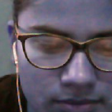

0.66


In [21]:
sample = train_dataset[0]
cv2_imshow((sample["face"].permute(1, 2, 0).numpy()*255))
print(sample["label"])

In [22]:
val_dataset = EngagementDataset(csv_file=path_to_csv, root_dir=val_frames_dir, transform=preprocess, bb_path='data/val_bb.pkl')

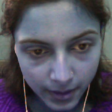

0.33


In [23]:
i = np.random.randint(0, len(val_dataset))
sample = val_dataset[i]
cv2_imshow((sample["face"].permute(1, 2, 0).numpy()*255))
print(sample["label"])

### Model

In [24]:
batch_size = 16
# Исправить!
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
feature_extractor = MobileFaceNet(512)
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/Final_Project/models/Pretrained/model_mobilefacenet.pth'))
model = nn.Sequential(
    feature_extractor,
    nn.Linear(512, 1)
)
model.train()
model.cuda()
print('')

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.SmoothL1Loss()
n_epochs = 10

In [27]:
# error - 1006th batch (batch_size = 16)

In [ ]:
for epoch in range(n_epochs):
    model.train()
    for batch in tqdm(train_dataloader):
        x = batch['face'].cuda()
        labels = batch['label'].cuda()
        preds = model(x).squeeze(1)
        loss = criterion(labels.float(), preds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_preds = []
        for batch in tqdm(val_dataloader):
            x = batch['face'].cuda()
            preds = model(x)
            val_preds.append(preds)
        val_preds_cuda = torch.cat(val_preds, dim=0).squeeze(1)
        val_labels = torch.Tensor(val_dataset.labels).float().cuda()
        val_loss = criterion(val_labels, val_preds_cuda).item()
        print(f'mobilenet_epoch{epoch}_loss_{val_loss:.2f}')
    torch.save(model, f'/content/drive/MyDrive/Final_Project/models/checkpoints/mobilenet_epoch{epoch}_loss_{val_loss:.2f}.pth')

  0%|          | 0/3215 [00:00<?, ?it/s]

In [ ]:
for p in tqdm(train_dataset.frame_paths):
    frame_image = cv2.imread(p)
    a = frame_image[0:2]


In [ ]:
None[-2:-1]

TypeError: ignored